In [ ]:
import numpy as np
import os
from google.colab import files
from sklearn.metrics import accuracy_score

print("Step 1: Upload your .npy files")
print("Please select 'maxvit_preds.npy' and 'effnet_se_preds.npy'.")
print("(Optional: Select 'test_true_labels.npy' if you want to see accuracy score)")

#Trigger the upload button
uploaded = files.upload()

#Load the files from the Colab local directory
try:
    #Adjust these names if your saved files have slightly different names
    pred_maxvit = np.load('maxvit_preds.npy')
    pred_effnet = np.load('effnet_se_preds.npy')
    print(f"\nLoaded MaxViT predictions: {pred_maxvit.shape}")
    print(f"Loaded EfficientNet predictions: {pred_effnet.shape}")

    #Check if labels were uploaded
    has_labels = False
    if 'test_true_labels.npy' in uploaded:
        y_true = np.load('test_true_labels.npy')
        has_labels = True
        print("Loaded True Labels. Accuracy will be calculated.")
    else:
        print("No labels found. Skipping accuracy calculation.")

    #Perform Ensemble
    print("\nStep 2: Computing Ensemble...")

    #Weights: Higher weight (0.7) to MaxViT because it had better results
    w1 = 0.7
    w2 = 0.3

    #Weighted Average
    ensemble_probs = (w1 * pred_maxvit) + (w2 * pred_effnet)

    #Get final class predictions (0, 1, 2...)
    final_preds = np.argmax(ensemble_probs, axis=1)

    #Show Results
    if has_labels:
        acc = accuracy_score(y_true, final_preds)
        print(f"\nFinal Ensemble Accuracy: {acc:.4f}")
    else:
        print(f"\nGenerated {len(final_preds)} predictions.")

    #Save and Download Result
    output_filename = 'final_ensemble_preds.npy'
    np.save(output_filename, final_preds)
    print(f"\nStep 3: Downloading '{output_filename}' to your PC...")
    files.download(output_filename)

except FileNotFoundError as e:
    print(f"\nError: Missing a file. Please ensure you uploaded both prediction files.\nDetails: {e}")
except Exception as e:
    print(f"\nAn error occurred: {e}")

Step 1: Upload your .npy files
Please select 'maxvit_preds.npy' and 'effnet_se_preds.npy'.
(Optional: Select 'test_true_labels.npy' if you want to see accuracy score)


Saving effnet_se_preds.npy to effnet_se_preds (1).npy
Saving maxvit_preds.npy to maxvit_preds.npy

Loaded MaxViT predictions: (760, 3)
Loaded EfficientNet predictions: (760, 3)
No labels found. Skipping accuracy calculation.

Step 2: Computing Ensemble...

Generated 760 predictions.

Step 3: Downloading 'final_ensemble_preds.npy' to your PC...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Set this to the main folder where your data starts
# Based on your previous messages, it seems to be this:
SEARCH_PATH = "/content/drive/MyDrive/skincareapp/acne clean pigmentation wrinkles/"

print(f"🕵️ Scanning structure of: {SEARCH_PATH}\n")

for root, dirs, files in os.walk(SEARCH_PATH):
    # Calculate depth to indent the print output nicely
    level = root.replace(SEARCH_PATH, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}📁 {os.path.basename(root)}/")

    # Show file counts
    images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    others = [f for f in files if not f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if images:
        print(f"{indent}    📸 {len(images)} images (e.g., {images[:3]})")
    if others:
        print(f"{indent}    📄 {len(others)} other files (e.g., {others[:3]})")

Mounted at /content/drive
🕵️ Scanning structure of: /content/drive/MyDrive/skincareapp/acne clean pigmentation wrinkles/

📁 /
    📸 5063 images (e.g., ['wrinkle_863.jpg', 'wrinkle_065.jpg', 'wrinkle_366.jpg'])
    📄 45 other files (e.g., ['labels.csv', 'train_split.csv', 'val_split.csv'])
📁 models/
    📁 reports/
        📸 11 images (e.g., ['roc_wrinkles.png', 'pr_acne.png', 'cm_acne.png'])
        📄 1 other files (e.g., ['val_predictions.csv'])
📁 keras_tuner/
    📁 eanet_skin_tuning/
        📄 2 other files (e.g., ['tuner0.json', 'oracle.json'])
        📁 trial_0/
            📄 1 other files (e.g., ['trial.json'])
        📁 trial_1/
            📄 1 other files (e.g., ['trial.json'])
        📁 trial_2/
            📄 1 other files (e.g., ['trial.json'])
        📁 trial_3/
            📄 1 other files (e.g., ['trial.json'])
        📁 trial_4/
            📄 1 other files (e.g., ['trial.json'])
    📁 resnet_skin_tuning_light/
        📄 1 other files (e.g., ['oracle.json'])
        📁 trial_0

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# ================= CONFIGURATION =================
# Path to your 'labels.csv'
DATA_DIR = "/content/drive/MyDrive/skincareapp/acne clean pigmentation wrinkles/"
LABELS_FILE = os.path.join(DATA_DIR, "labels.csv")

# Your calculated predictions (uploaded to Colab)
PATH_MAXVIT = "maxvit_preds.npy"
PATH_EFFNET = "effnet_se_preds.npy"

# The output classes of your model (Indices 0, 1, 2)
# Your notebook used these 3 specific classes:
MODEL_CLASSES = ['Acne', 'Pigmentation', 'Wrinkles']
# =================================================

try:
    print("--- Step 1: Loading Data ---")

    if not os.path.exists(LABELS_FILE):
        print(f"❌ Error: 'labels.csv' not found at {LABELS_FILE}")
    elif not os.path.exists(PATH_MAXVIT) or not os.path.exists(PATH_EFFNET):
        print(f"❌ Error: Please upload 'maxvit_preds.npy' and 'effnet_se_preds.npy' to Colab files.")
    else:
        # Load Labels
        df = pd.read_csv(LABELS_FILE)
        print(f"✅ Loaded labels.csv: {len(df)} rows")

        # Load Predictions
        p_max = np.load(PATH_MAXVIT)
        p_eff = np.load(PATH_EFFNET)
        print(f"✅ Loaded Predictions. MaxViT: {p_max.shape}, EffNet: {p_eff.shape}")

        # --- Step 2: Reconstruct the Split (CRITICAL FIX) ---
        print("🔄 Reconstructing Split using 'stratify' on class columns...")

        # We need to find the exact columns used in the notebook: "acne", "pigmentation", "wrinkles"
        # We search case-insensitive to be safe
        cols_found = []
        for target in ["acne", "pigmentation", "wrinkles"]:
            for col in df.columns:
                if col.lower() == target:
                    cols_found.append(col)
                    break

        if len(cols_found) != 3:
            print(f"⚠️ Warning: Could not find all 3 class columns. Found: {cols_found}")
            print("Trying to proceed with what we have, but split might be wrong.")
            stratify_target = df[cols_found] if cols_found else None
        else:
            print(f"   Stratifying on columns: {cols_found}")
            stratify_target = df[cols_found]

        # EXACT SAME SPLIT PARAMETERS AS YOUR NOTEBOOK
        train_val_df, test_df = train_test_split(
            df,
            test_size=0.15,
            random_state=42,
            stratify=stratify_target
        )

        print(f"   Test Set Size: {len(test_df)}")

        # --- Step 3: Ensemble & Thresholding ---
        if len(test_df) == len(p_max):
            print("✅ Alignment Success! Rows match predictions.")

            # Weighted Ensemble (70% MaxViT)
            ensemble_probs = (0.7 * p_max) + (0.3 * p_eff)

            final_labels = []
            for row in ensemble_probs:
                max_score = np.max(row)
                max_index = np.argmax(row)

                # Logic: If model isn't confident (<50%), it's Clean.
                if max_score < 0.5:
                    final_labels.append("Clean")
                else:
                    final_labels.append(MODEL_CLASSES[max_index])

            # --- Step 4: Save Result ---
            submission = pd.DataFrame({
                'filename': test_df['filename'].apply(os.path.basename).values,
                'label': final_labels
            })

            csv_name = "submission_perfected.csv"
            submission.to_csv(csv_name, index=False)
            print(f"\n🎉 Success! Created '{csv_name}'")
            print(submission.head())

            from google.colab import files
            files.download(csv_name)

        else:
            print(f"❌ Mismatch: Test DF ({len(test_df)}) vs Preds ({len(p_max)})")
            print("This implies 'labels.csv' has changed since training, or duplicate files exist.")

except Exception as e:
    print(f"\n❌ Error: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Step 1: Loading Data ---
✅ Loaded labels.csv: 5062 rows
✅ Loaded Predictions. MaxViT: (760, 3), EffNet: (760, 3)
🔄 Reconstructing Split using 'stratify' on class columns...
   Stratifying on columns: ['acne', 'pigmentation', 'wrinkles']
   Test Set Size: 760
✅ Alignment Success! Rows match predictions.

🎉 Success! Created 'submission_perfected.csv'
              filename     label
0         acne_630.jpg      Acne
1   attractive_614.jpg     Clean
2      wrinkle_582.jpg  Wrinkles
3  attractive_1275.jpg     Clean
4         acne_670.jpg      Acne


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Step 1: Loading Data & Predictions ---
✅ Loaded Labels: 5062
✅ Loaded Predictions: 760
🔄 Reconstructing Test Split...

📊 FINAL EVALUATION REPORT
✅ Accuracy: 0.9987 (99.87%)

--- Classification Report ---
              precision    recall  f1-score   support

        Acne       1.00      1.00      1.00       211
       Clean       1.00      1.00      1.00       315
Pigmentation       0.99      1.00      0.99        80
    Wrinkles       1.00      1.00      1.00       154

    accuracy                           1.00       760
   macro avg       1.00      1.00      1.00       760
weighted avg       1.00      1.00      1.00       760



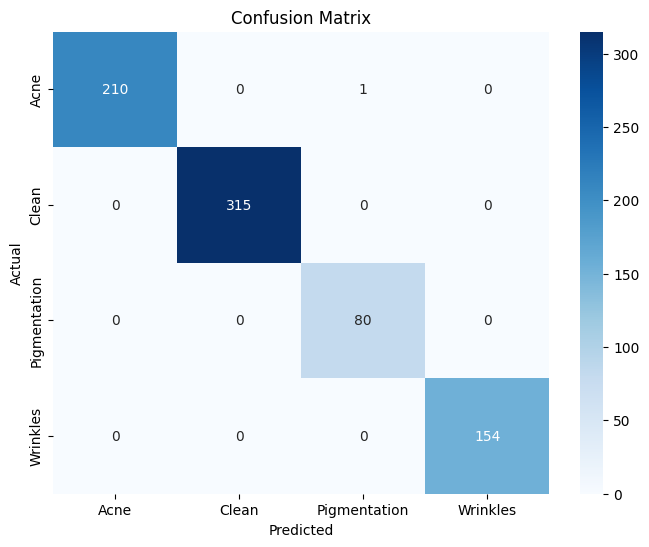


📉 Validation Loss (Binary Crossentropy): 0.0119
(Note: Lower is better. This measures confidence on the 3 disease classes.)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# ================= CONFIGURATION =================
# Update paths if needed
DATA_DIR = "/content/drive/MyDrive/skincareapp/acne clean pigmentation wrinkles/"
LABELS_FILE = os.path.join(DATA_DIR, "labels.csv")

# Prediction files (Make sure these are uploaded or in Drive)
PATH_MAXVIT = "maxvit_preds.npy"
PATH_EFFNET = "effnet_se_preds.npy"

# Class names
MODEL_CLASSES = ['Acne', 'Pigmentation', 'Wrinkles']
ALL_CLASSES = ['Acne', 'Clean', 'Pigmentation', 'Wrinkles']
# =================================================

try:
    print("--- Step 1: Loading Data & Predictions ---")

    if os.path.exists(LABELS_FILE) and os.path.exists(PATH_MAXVIT) and os.path.exists(PATH_EFFNET):
        # Load
        df = pd.read_csv(LABELS_FILE)
        p_max = np.load(PATH_MAXVIT)
        p_eff = np.load(PATH_EFFNET)

        print(f"✅ Loaded Labels: {len(df)}")
        print(f"✅ Loaded Predictions: {len(p_max)}")

        # --- Step 2: Reconstruct Ground Truth (y_true) ---
        print("🔄 Reconstructing Test Split...")

        # Detect stratification columns (same as before)
        cols_found = [c for c in ["acne", "pigmentation", "wrinkles"] if any(x.lower() == c for x in df.columns)]
        stratify_target = df[cols_found] if len(cols_found) == 3 else df[df.columns[1]]

        train_val_df, test_df = train_test_split(
            df,
            test_size=0.15,
            random_state=42,
            stratify=stratify_target
        )

        # Extract True Labels from Filenames
        def get_true_label(filename):
            name = filename.lower()
            if 'acne' in name: return 'Acne'
            if 'pigmentation' in name: return 'Pigmentation'
            if 'wrinkle' in name: return 'Wrinkles'
            if 'attractive' in name or 'clean' in name: return 'Clean'
            return 'Unknown'

        y_true = test_df['filename'].apply(os.path.basename).apply(get_true_label).values

        # --- Step 3: Generate Predictions (y_pred) ---
        # Weighted Ensemble
        ensemble_probs = (0.7 * p_max) + (0.3 * p_eff)

        y_pred = []
        for row in ensemble_probs:
            if np.max(row) < 0.5:
                y_pred.append("Clean")
            else:
                y_pred.append(MODEL_CLASSES[np.argmax(row)])

        # --- Step 4: Calculate Metrics ---
        print("\n" + "="*40)
        print("📊 FINAL EVALUATION REPORT")
        print("="*40)

        # Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"✅ Accuracy: {acc:.4f} ({acc*100:.2f}%)")

        # Detailed Report (Precision, Recall, F1)
        print("\n--- Classification Report ---")
        print(classification_report(y_true, y_pred, target_names=ALL_CLASSES))

        # --- Step 5: Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred, labels=ALL_CLASSES)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=ALL_CLASSES, yticklabels=ALL_CLASSES)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # --- Step 6: Loss Calculation (Optional but requested) ---
        # Note: We calculate Binary Crossentropy on the 3 disease classes
        # (Clean is implicitly handled by low probabilities)
        try:
            # Reconstruct binary targets for the 3 classes
            y_true_binary = []
            for label in y_true:
                row = [0, 0, 0] # [Acne, Pigm, Wrinkle]
                if label == 'Acne': row[0] = 1
                elif label == 'Pigmentation': row[1] = 1
                elif label == 'Wrinkles': row[2] = 1
                # Clean remains [0, 0, 0]
                y_true_binary.append(row)

            y_true_binary = np.array(y_true_binary)

            # Calculate Log Loss
            loss = log_loss(y_true_binary, ensemble_probs)
            print(f"\n📉 Validation Loss (Binary Crossentropy): {loss:.4f}")
            print("(Note: Lower is better. This measures confidence on the 3 disease classes.)")

        except Exception as e:
            print(f"Could not calc loss: {e}")

    else:
        print("❌ Error: Missing files. Please check paths.")

except Exception as e:
    print(f"\n❌ Error: {e}")